# XyloAudio 3 `AFESim` with Analog Microphone Tutorial

XyloAudio 3 HDK contains a signal pre-processing module which is designed to encode an audio signal in the form of spike trains.
This module is named as **A**udio **F**ront-**E**nd, and it efficiently:

* captures audio from a microphone, 
* converts analog signals into digital waveforms, 
* performs band-pass filtering to isolate specific frequency ranges, 
* encodes signals into spike trains, 
* and ultimately delivers these spike trains to the Spiking Neural Network (SNN) core.

Previous tutorial [AFESim Quick Start Tutorial](afesim.html) explains the basics of the `AFESim` module and its practical usage. This tutorial focuses the `AFESim` with **A**utomatic **G**ain **C**ontrol `AGC` enabled analog microphone input, and explains the usage of combined `AFESimAGC` module in beginner friendly manner.

## Getting Started

Let's first remember the block diagram of the input pre-processing pipeline.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from IPython.display import Image

Image("figures/av3_block.png")

We see that there are two different microphones capturing the audio signals from air.
One of them is a **digital PDM microphone**, and the other is an **analog microphone**.
The red path, which is the one with an analog microphone, has some extra modules for automatic gain control and analog to digital conversion.
The blue path, which is the one with a digital microphone, does not need an ADC but it employs a polyphase low pass filter to reduce the speed of the signal and to obtain a 14-bit integer signal.

For the blue path, please refer to [AFESim with Digital Microphone](afesim_pdm.html).

In this tutorial, we're investigating the red path, in oder words, **analog microphone** input.

In [3]:
Image("figures/afesimagc.png")

* Programmable Gain Amplifier
* Analog to Digital Converter
* Envelope Controller
* Gain Smoother

Please refer to [AFESim Quick Start Tutorial](afesim.html) for the details of the rest of the modules.

In [4]:
import json

import librosa
from doc_utils import (
    generate_chirp,
    plot_chirp_signal,
    plot_divisive_normalization_output,
    plot_filter_bank_output,
    plot_raster_output,
)

from rockpool.devices.xylo.syns65302 import (
    AFESimAGC,
    DEFAULT_PGA_COMMAND_IN_FIXED_GAIN_FOR_PGA_MODE,
    RISE_TIME_CONSTANT,
    FALL_TIME_CONSTANT,
    RELIABLE_MAX_HYSTERESIS,
    NUM_BITS_GAIN_QUANTIZATION,
)

from samna.xyloA3.configuration import InputInterfaceConfig


## Load an audio file

The audio file we'll use here is a chirp signal whose frequency increases linearly from 20 Hz to 20 kHz in 4 seconds. We do not need to worry too much about the sampling rate because `AFESimAGC` will resample the signal to **50 kHz**, **100 kHz**, or **200 kHz** automatically, depending on the oversampling rate.

Still, we need to make sure that the signal is in the range of [-1, 1]. Also, we need to make sure that the signal meets the Nyquist criteria, which means that the highest frequency in the signal should be less than half of the sampling rate. 

Let's load the audio file and plot the waveform. For the sake of visualisation, we will only use the first 0.1 second of the audio file.

NOTE : You can generate your chirp signal using `doc_utils.generate_chirp()` function, or you can use any other audio file you want. Just make sure you provide real or dummy `start_freq` and `end_freq` values if you're planning to use the plotting utils provided here.

In [5]:
# generate_chirp(filename="freq_sweep.wav", start_freq=20, end_freq=20_000, duration=4.0)

In [6]:
filename = "freq_sweep.wav"

signal, sr = librosa.load(filename, sr=None)
audio_specs = json.load(open("freq_sweep.json", "r"))
start_freq = audio_specs["start_freq"]
end_freq = audio_specs["end_freq"]

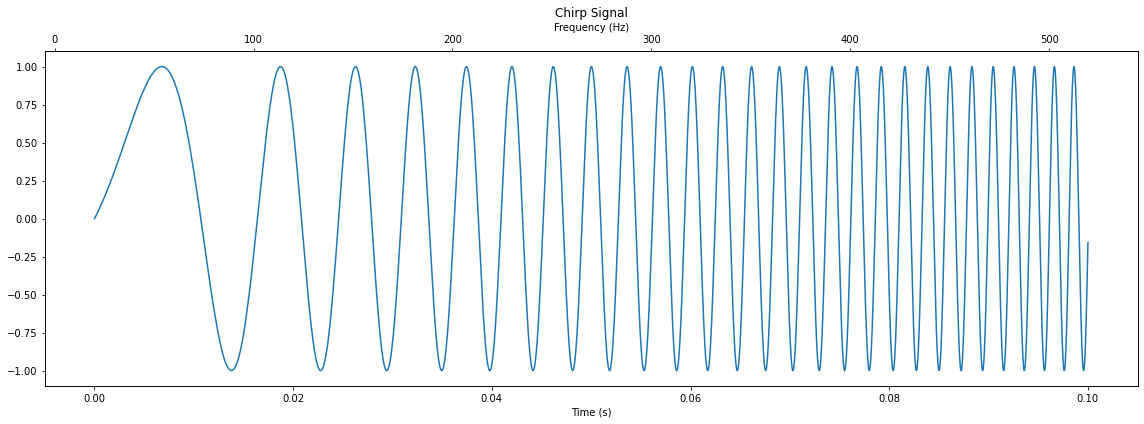

In [7]:
fig = plot_chirp_signal(
    signal=signal, sr=sr, t_cut=0.1, start_freq=start_freq, end_freq=end_freq
)
fig.show()

## Construct AFESim

As explained in [AFESim Quick Start Tutorial](afesim.html), there are two methods to construct an `AFESim` object. It's the same for `AFESimExternal`, `AFESimPDM` or `AFESimAGC`. Here we'll use the `from_specification` method.

In [8]:
afesim_agc = AFESimAGC.from_specification(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    rate_scale_factor=63,
    low_pass_averaging_window=82e-3,
    dn_EPS=1,
    fixed_threshold_vec=None,
    dt=1e-3,
    oversampling_factor = 2,
    enable_gain_smoother = True,
    fixed_gain_for_PGA_mode = False,
    fixed_pga_gain_index = DEFAULT_PGA_COMMAND_IN_FIXED_GAIN_FOR_PGA_MODE,
    pga_gain_index_variation = None,
    ec_amplitude_thresholds = None,
    ec_waiting_time_vec = None,
    ec_rise_time_constant = RISE_TIME_CONSTANT,
    ec_fall_time_constant = FALL_TIME_CONSTANT,
    ec_reliable_max_hysteresis = RELIABLE_MAX_HYSTERESIS,
    num_bits_gain_quantization = NUM_BITS_GAIN_QUANTIZATION,
)

In [9]:
afesim_agc

AFESimAGC  with shape (1, 16) {
    AGCADC '0_AGCADC' with shape (1, 1) {
        ADC 'adc' with shape (1, 1) {
            AntiAliasingDecimationFilter 'anti_aliasing_filter' with shape (1, 1)
        }
        ResampleAudio 'resample' with shape (1, 1)
        Amplifier 'amplifier' with shape (1, 1)
        EnvelopeController 'envelope_controller' with shape (1, 1)
        GainSmoother 'gain_smoother' with shape (1, 1)
    }
    ChipButterworth '1_ChipButterworth' with shape (1, 16)
    DivisiveNormalization '2_DivisiveNormalization' with shape (16, 16)
    Raster '3_Raster' with shape (16, 16)
}

## Run the simulation

We need to run the simulation to get the output. The output of the `AFESimPDM` is a 16-channel 4-bit raster. However, there are also intermediate outputs which we can access. Below, we'll go through the outputs one by one.

First, let's run the simulation and get the output and the dictionaries.

Different from the other `AFESim` derivatives, `AFESimPDM` simulation requires that the signal should be far away from [-1,1] limits. Following that, we scale the input signal by 0.9 to make sure.

In [10]:
out_agc, state_agc, rec_agc = afesim_agc((signal, sr))

In [11]:
out_agc.shape

(4000, 16)

In [12]:
print(rec_agc.keys())

dict_keys(['0_AGCADC', '0_AGCADC_output', '1_ChipButterworth', '1_ChipButterworth_output', '2_DivisiveNormalization', '2_DivisiveNormalization_output', '3_Raster', '3_Raster_output'])


## AGC Block Response

The first step is the analog microphone's simulated response to the signal. It 
1. Up-scales the signal to `target sampling rate x oversampling factor` to avoid anti-aliasing
2. Down-scales again using decimation filter
3. ..

As a result, we obtain a 14-bit quantized signal from the `AGCADC` module

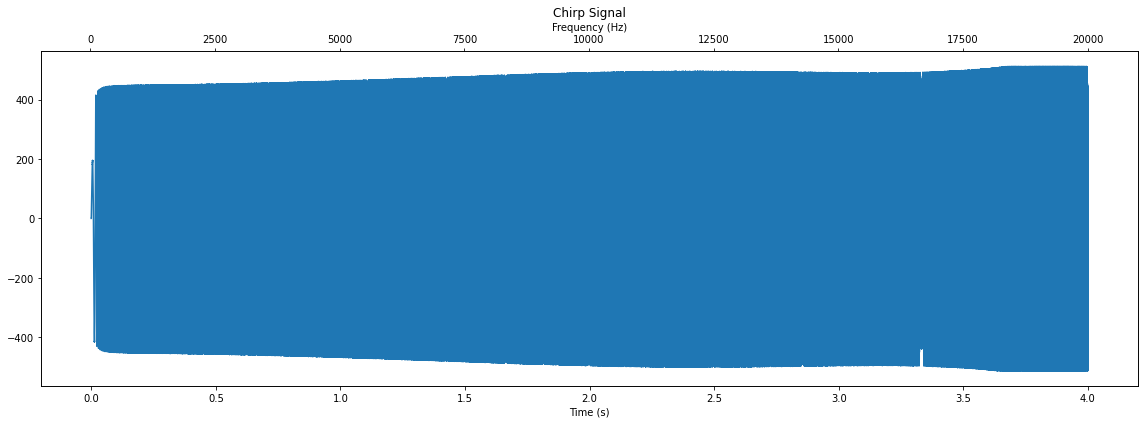

In [13]:
fig = plot_chirp_signal(
    signal=rec_agc["0_AGCADC_output"],
    sr=afesim_agc.audio_sampling_rate,
    t_cut=None,
    start_freq=start_freq,
    end_freq=end_freq,
)
fig.show()

## Filter Bank output

The first stage is the filterbank, and we can fetch the output with key `"1_ChipButterworth_output"`. The filterbank output is a 16-channel (max) 14-bit integer signal, which is the input to the divisive normalization block.

In the case we select a sub-set of channels through `"select_filters"`, the filterbank output will have exactly the selected number of channels.
Let's plot and observe the filtering effect!

Note that here the amplitude of the signal output is smaller than the other `AFESim` derivatives. The reason is that the original `AGCADC` output is 10-bits instead of 14-bits. Even though it can be adjusted, it's probably easier to deal with this at the spike encoding level. 

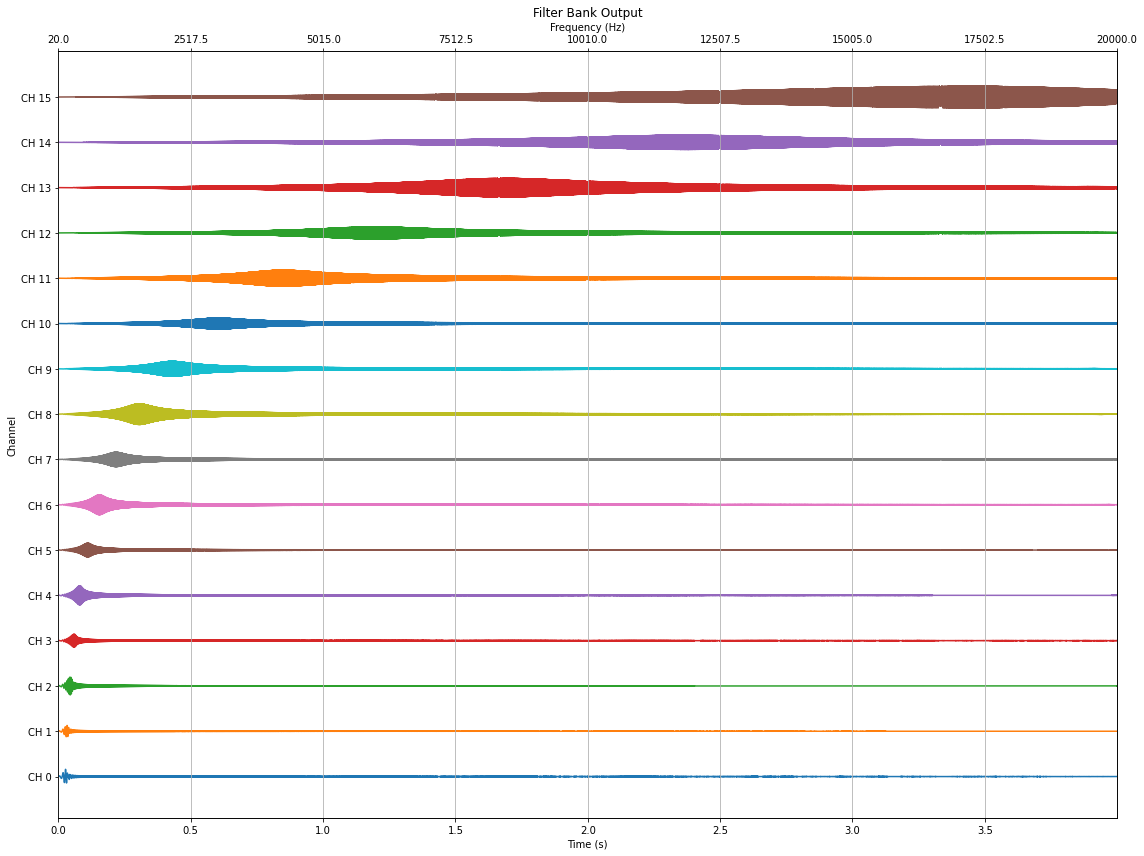

In [14]:
fig = plot_filter_bank_output(
    rec_agc["1_ChipButterworth_output"],
    afesim_agc.audio_sampling_rate,
    start_freq=start_freq,
    end_freq=end_freq,
    stagger=1e6,
)
fig.show()

## Spike Encoding

The second stage is the spike generation, and we can fetch the output with key `"2_DivisiveNormalization_output"`. The divisive normalization output is 16-channel (max) **1-bit** spike train.

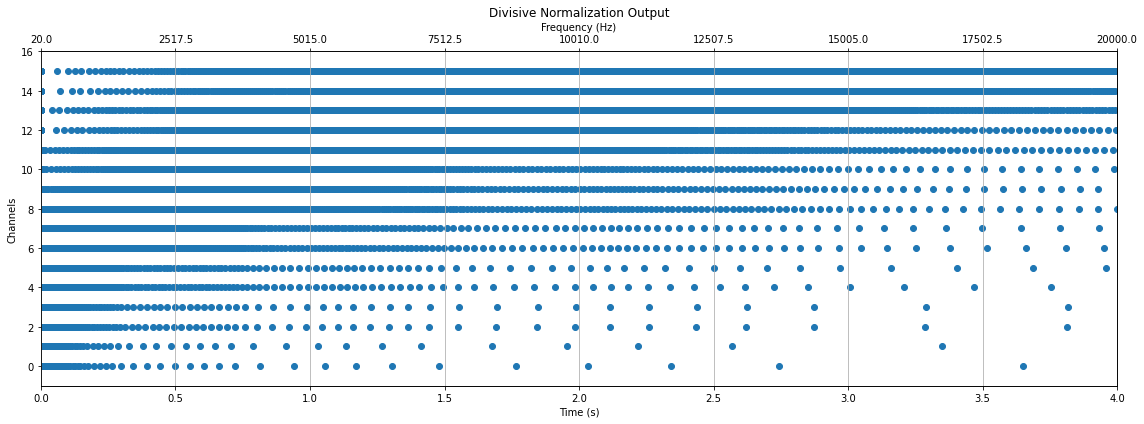

In [15]:
fig = plot_divisive_normalization_output(
    rec_agc["2_DivisiveNormalization_output"],
    afesim_agc.audio_sampling_rate,
    start_freq=start_freq,
    end_freq=end_freq,
)
fig.show()

Here the the figure shows the 1-bit 16 channel spike train obtained at the output of the divisive normalization block. We can see that the spikes are densely distributed in the high power regions of the signal.

## Accumulated spikes

Even though the spike encoding obtained at the output of the divisive normalization block is sufficient for the SNN core, we can also accumulate the spikes in a 16-channel 4-bit raster. This provides us with a lower SNN clock rate, and better power efficiency. For that reason, we have the rastering block. Rastering block accumulates spikes given the `"down_sampling_factor"` set at the construction of the `AFESim` object. `"down_sampling_factor"` = 50 means that the rastering block accumulates 50 timesteps of spikes into a single timestep. This means that the SNN core will run at 50 times lower clock rate compared to the AFE block.

Let's check shapes of the outputs, and compare the dt of the AFE block and the SNN core.

In [16]:
__intermediate_shape = rec_agc["2_DivisiveNormalization_output"].shape
print(f"Divisive Normalization output shape: {__intermediate_shape}")
print(f"Down Sampling Factor: {afesim_agc.down_sampling_factor}")
print(
    f"{__intermediate_shape[0]} / {afesim_agc.down_sampling_factor} = {__intermediate_shape[0] / afesim_agc.down_sampling_factor}"
)
print(f"\nAFESimPDM output shape: {out_agc.shape}")

__snn_freq = afesim_agc.audio_sampling_rate / afesim_agc.down_sampling_factor
print(f"SNN core operating frequency: {__snn_freq} Hz")
print(f"dt = 1/{__snn_freq}s = {1/__snn_freq}")
print(f"Remember dt = {afesim_agc.dt}s")

# - For future reference
if afesim_agc.dt == 1 / __snn_freq:
    print("\nEverything looks good!")
else:
    raise ValueError("Something is wrong!")

Divisive Normalization output shape: (200000, 16)
Down Sampling Factor: 50
200000 / 50 = 4000.0

AFESimPDM output shape: (4000, 16)
SNN core operating frequency: 1000.0 Hz
dt = 1/1000.0s = 0.001
Remember dt = 0.001s

Everything looks good!


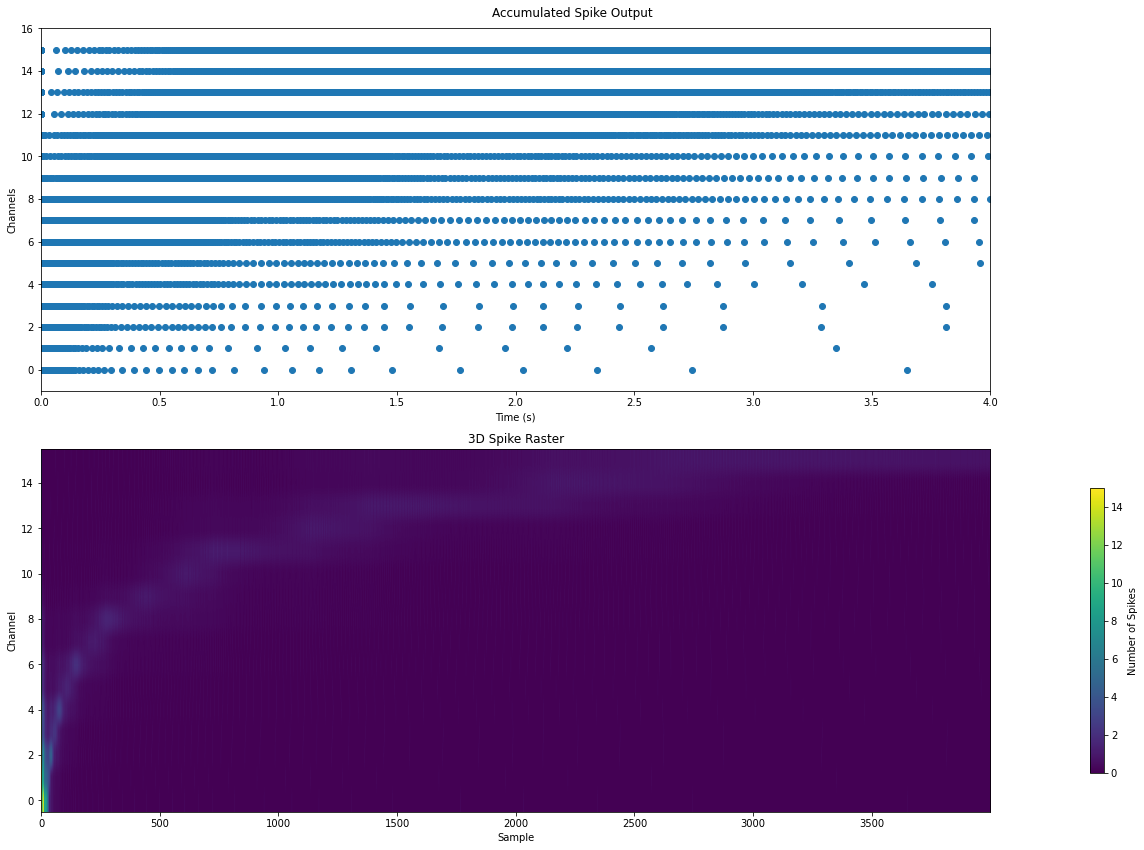

In [17]:
fig = plot_raster_output(out_agc, dt=afesim_agc.dt)
fig.show()

Due to that down-sampling, and accumulation into a 4-bit spike representation, now the spike raster plot is not self-sufficient to visualize the output. The second figure encodes the number of spikes in one timestep into the color of the pixel. The greener the pixel, the more spikes are accumulated in that timestep.

Now you're ready to use `AFESimAGC` in your own projects. Please feel free to play with the parameters and see how the output changes!

* For a tutorial without utilizing the microphone paths, check [AFESim Quick Start Tutorial](afesim.html).
* For digital microphone, please check the [AFESim with Digital Microphone](afesim_pdm.html) tutorial.